# DataSynthesizer Usage (correlated attribute mode)

> This is a quick demo to use DataSynthesizer in correlated attribute mode.

### Step 1 import packages

In [1]:
from time import time

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import pandas as pd

### Step 2 user-defined parameteres

In [2]:
# input dataset
input_data = './data/adult_with_no_names.csv'
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f'./out/{mode}/description-country-text.json'
synthetic_data = f'./out/{mode}/sythetic_data-country-text.csv'

In [12]:
na_values={
    'capital-gain': 99999,
    'capital-loss': 99999,
    'hours-per-week': 99,
    'workclass': '?',
    'native-country': '?',
    'occupation': '?'}

df = pd.read_csv(input_data, skipinitialspace=True, na_values=na_values)#.reset_index().to_csv(input_data, index=False)
df.apply(lambda x: x.unique().size, axis=0)
df.dtypes.loc[df.dtypes=='O']
categorical_attributes = (df.dtypes=='O').to_dict()
df#.shape[0]
categorical_attributes
# df.drop(['lastname', 'firstname'], axis=1).to_csv('./data/adult_with_no_names.csv', index=False)

{'index': False,
 'age': False,
 'workclass': True,
 'fblwgt': False,
 'education': True,
 'education_num': False,
 'martial-status': True,
 'occupation': True,
 'relationship': True,
 'race': True,
 'sex': True,
 'captial-gains': False,
 'capial-loss': False,
 'hours-per-week': False,
 'native-country': True,
 'income': True}

In [4]:
df['native-country'].value_counts()
df['native-country'].nunique()

41

Default values set here, change here if needed.

In [5]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# specify categorical attributes
categorical_attributes = {}  # {'native-country': True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'index': True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = df.shape[0] # Here 32561 is the same as input dataset, but it can be set to another number.

### Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [6]:
start = time()
describer = DataDescriber(category_threshold=threshold_value, null_values=na_values)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT capial-loss
Adding attribute sex
Adding attribute relationship
Adding attribute martial-status
Adding attribute age
Adding attribute income
Adding attribute occupation
Adding attribute workclass
Adding attribute education
Adding attribute education_num
Adding attribute hours-per-week
Adding attribute race
Adding attribute captial-gains
Adding attribute fblwgt
========================== BN constructed ==========================


In [7]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    sex            has parents ['capial-loss'].
    relationship   has parents ['sex', 'capial-loss'].
    martial-status has parents ['relationship', 'capial-loss'].
    age            has parents ['martial-status', 'relationship'].
    income         has parents ['martial-status', 'capial-loss'].
    occupation     has parents ['age', 'sex'].
    workclass      has parents ['occupation', 'capial-loss'].
    education      has parents ['occupation', 'age'].
    education_num  has parents ['education', 'capial-loss'].
    hours-per-week has parents ['education', 'age'].
    race           has parents ['occupation', 'relationship'].
    captial-gains  has parents ['education', 'income'].
    fblwgt         has parents ['hours-per-week', 'relationship'].


### Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [8]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)
print('took {} seconds'.format(time() - start))

took 109.31767702102661 seconds


### Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

#### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [9]:
# Read both datasets using Pandas.
input_df = pd.read_csv(input_data, skipinitialspace=True, na_values=na_values)
synthetic_df = pd.read_csv(synthetic_data)
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

#### 5.2 compare histograms between input and synthetic datasets.

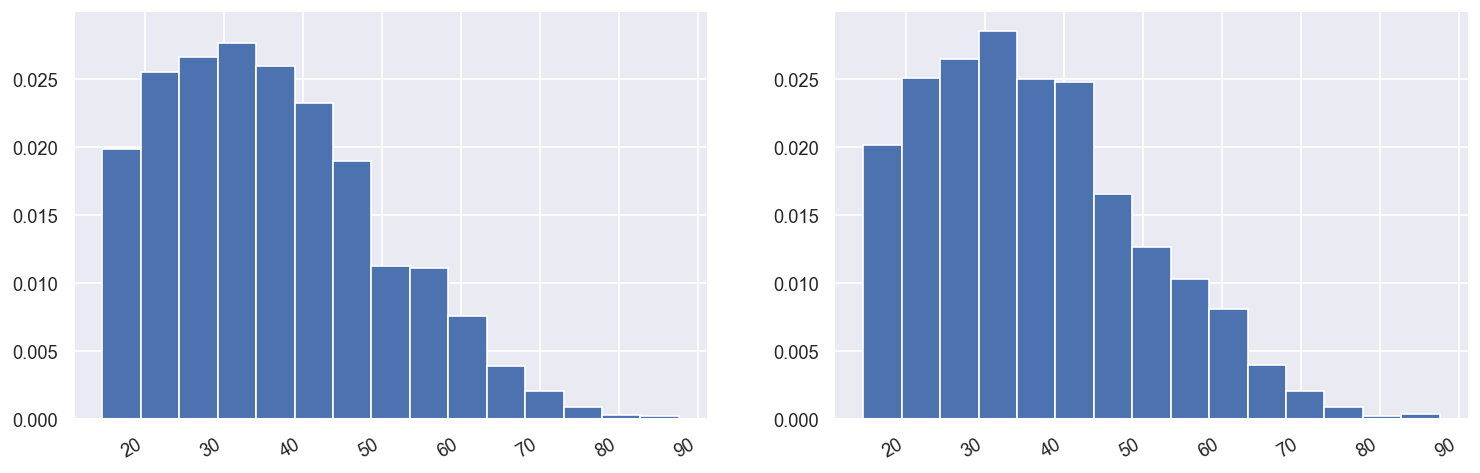

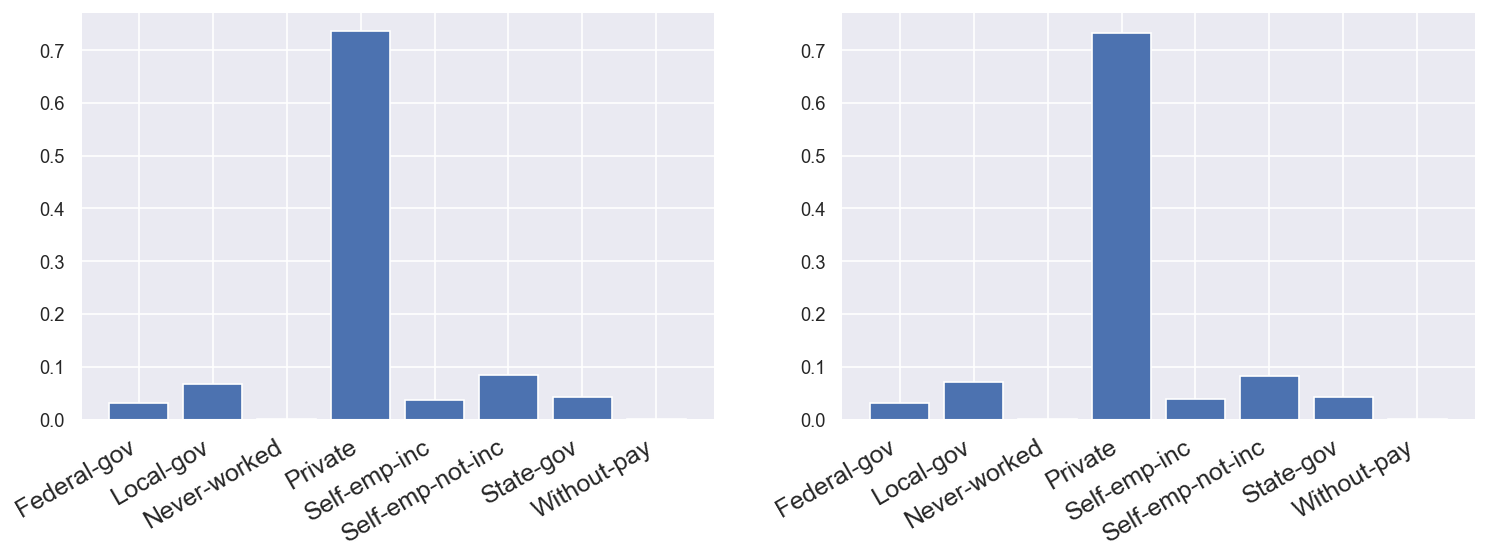

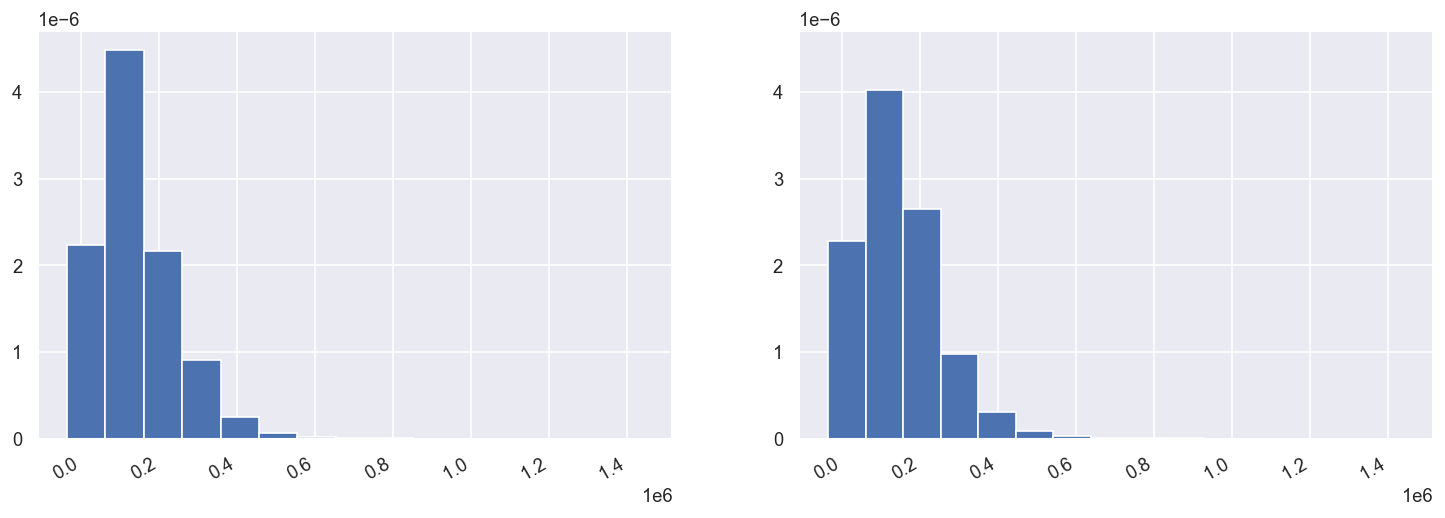

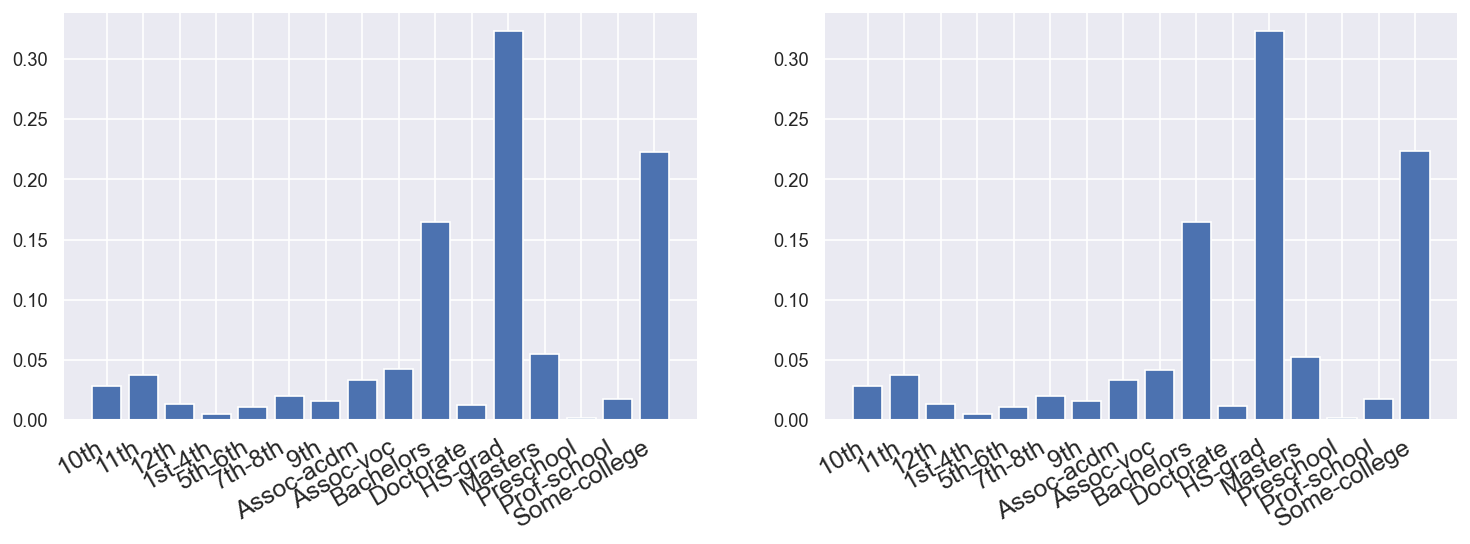

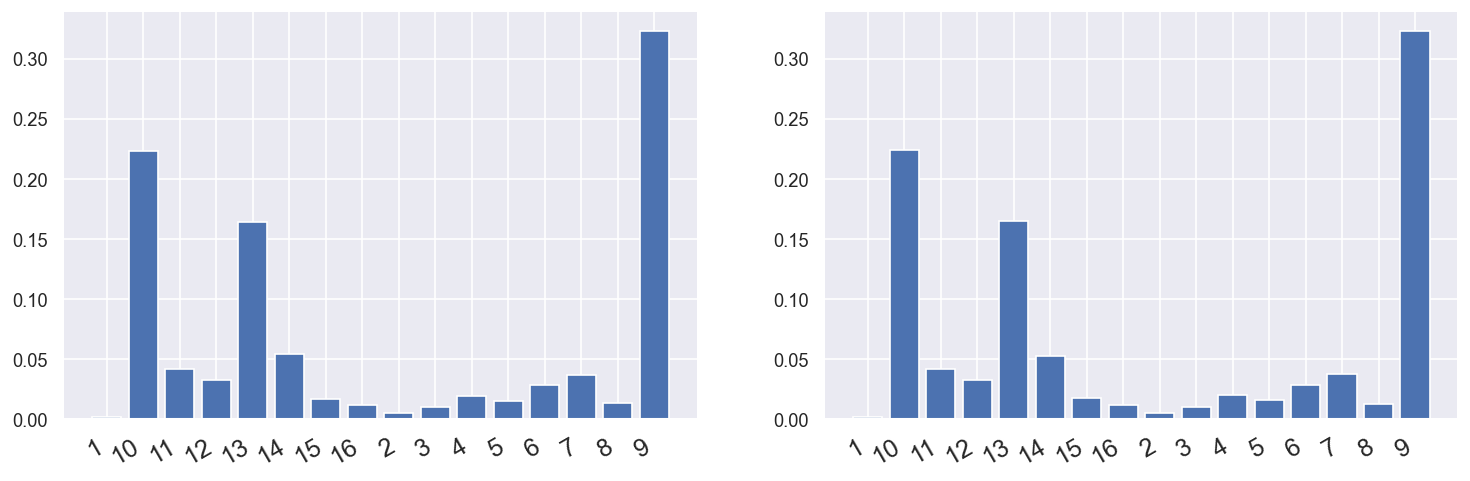

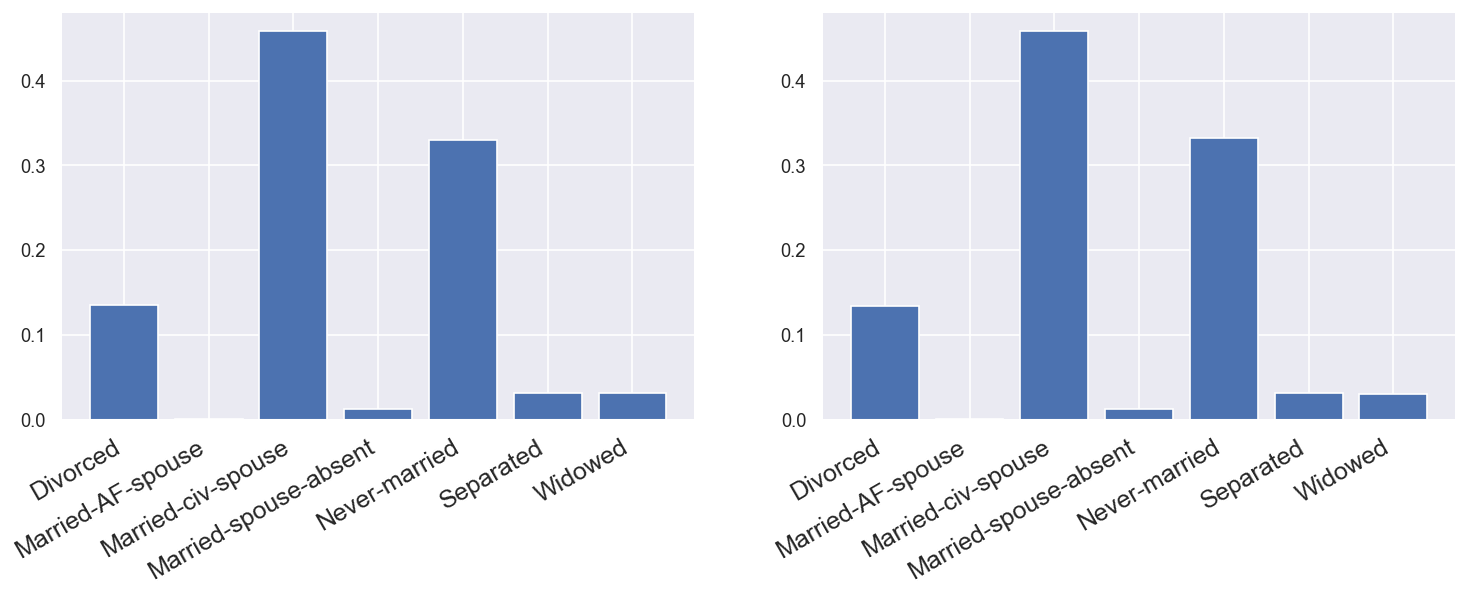

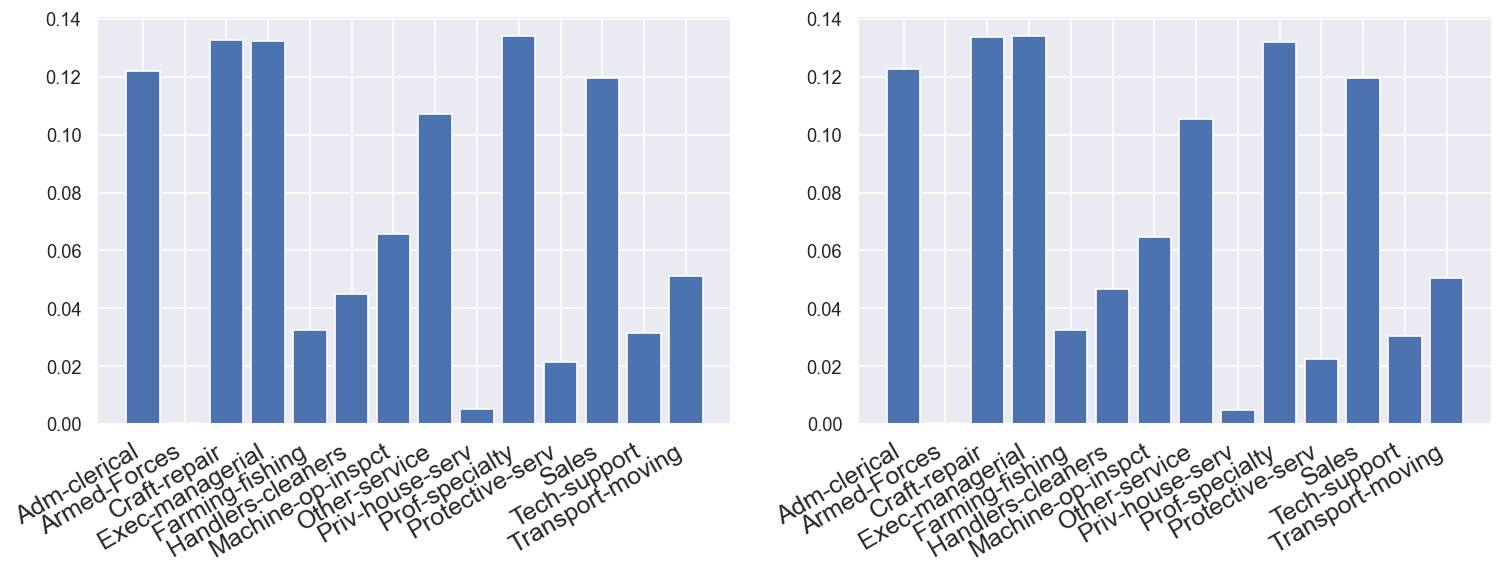

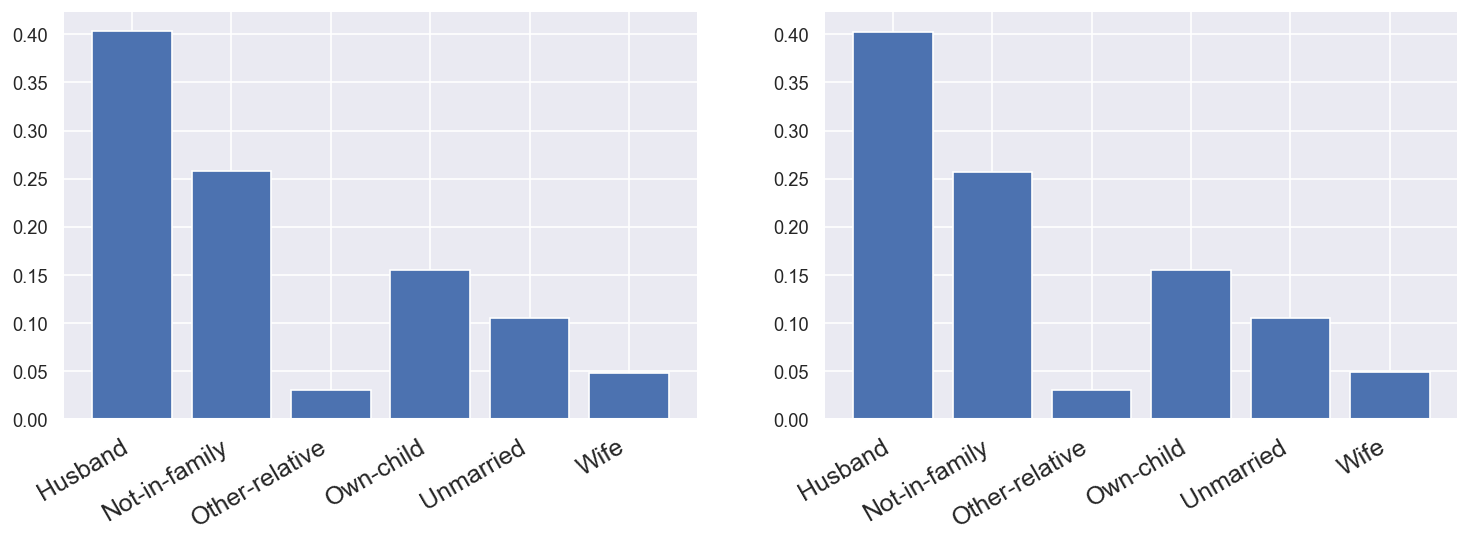

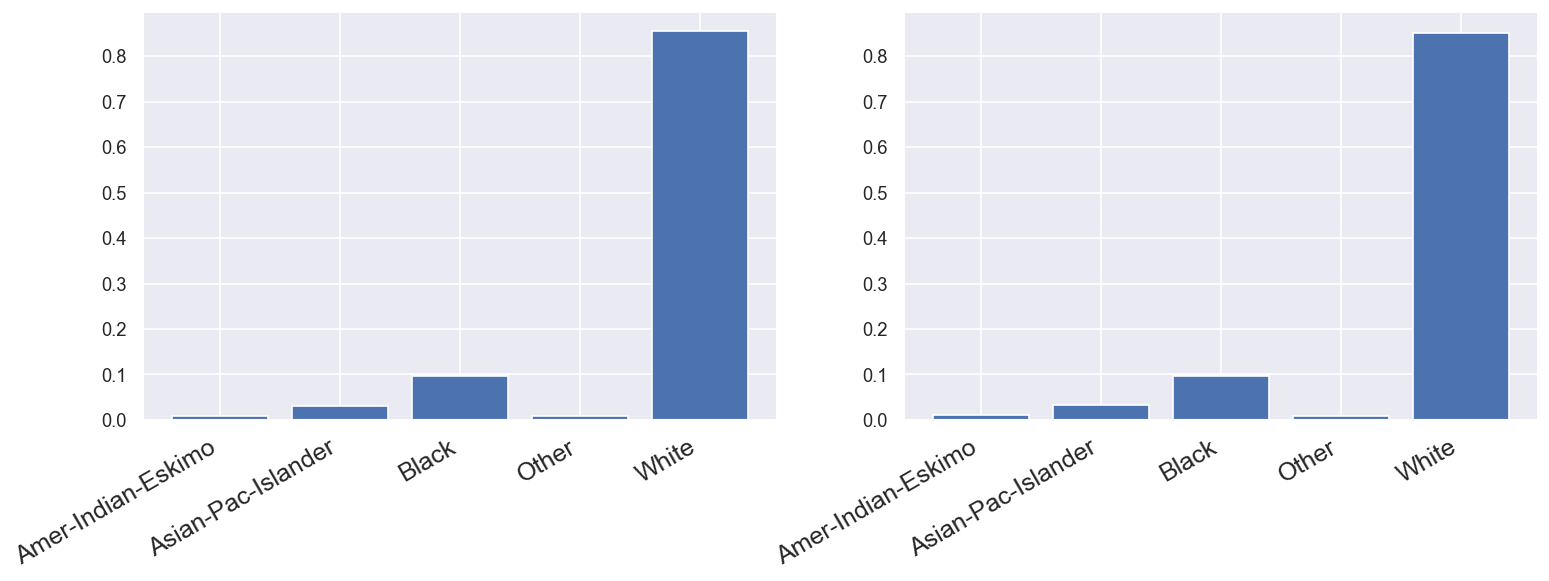

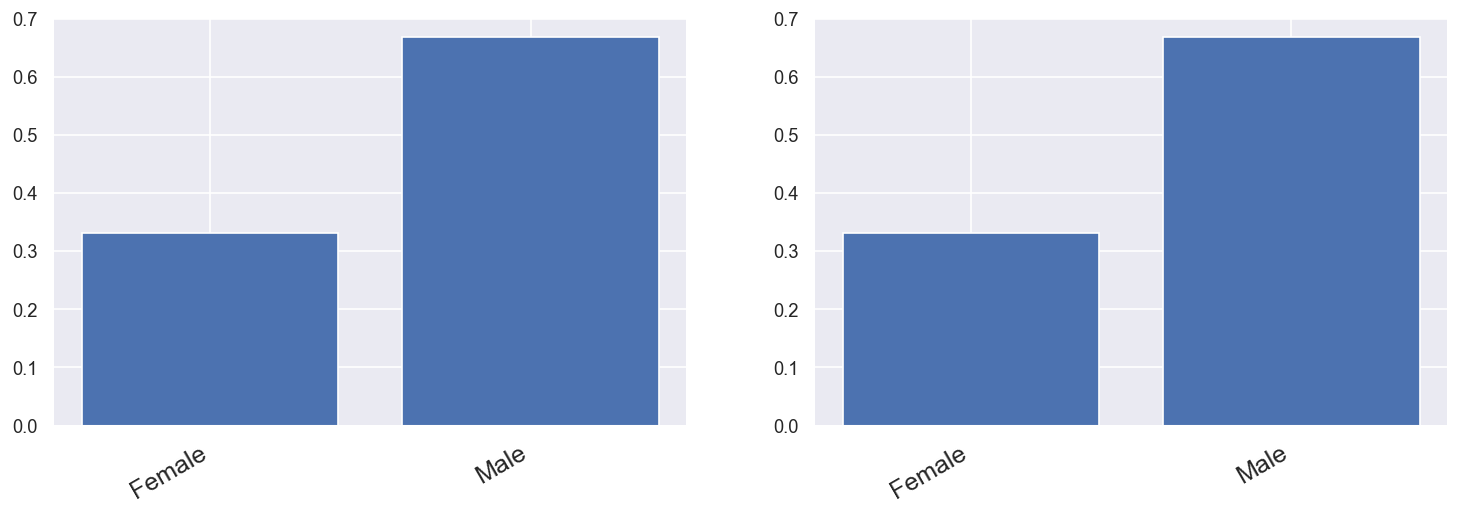

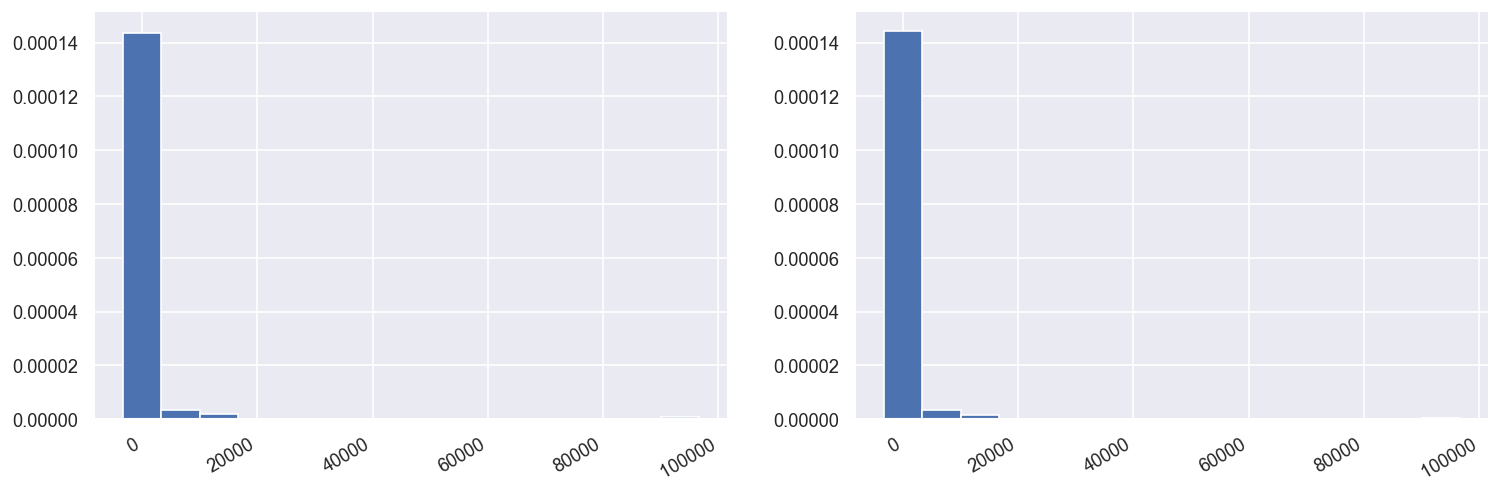

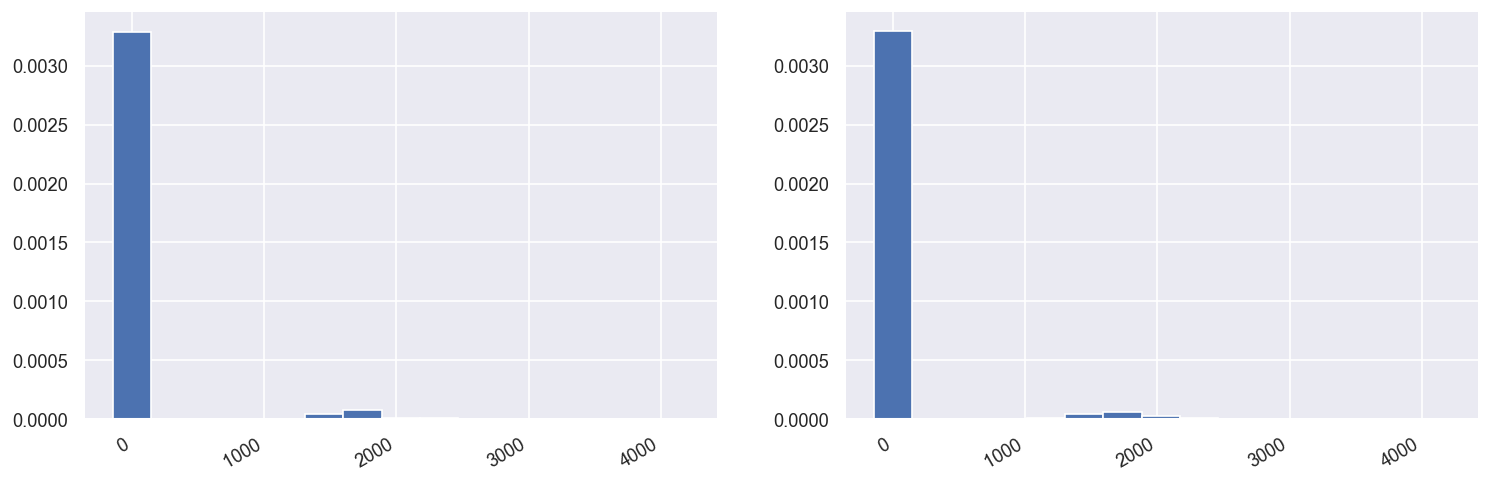

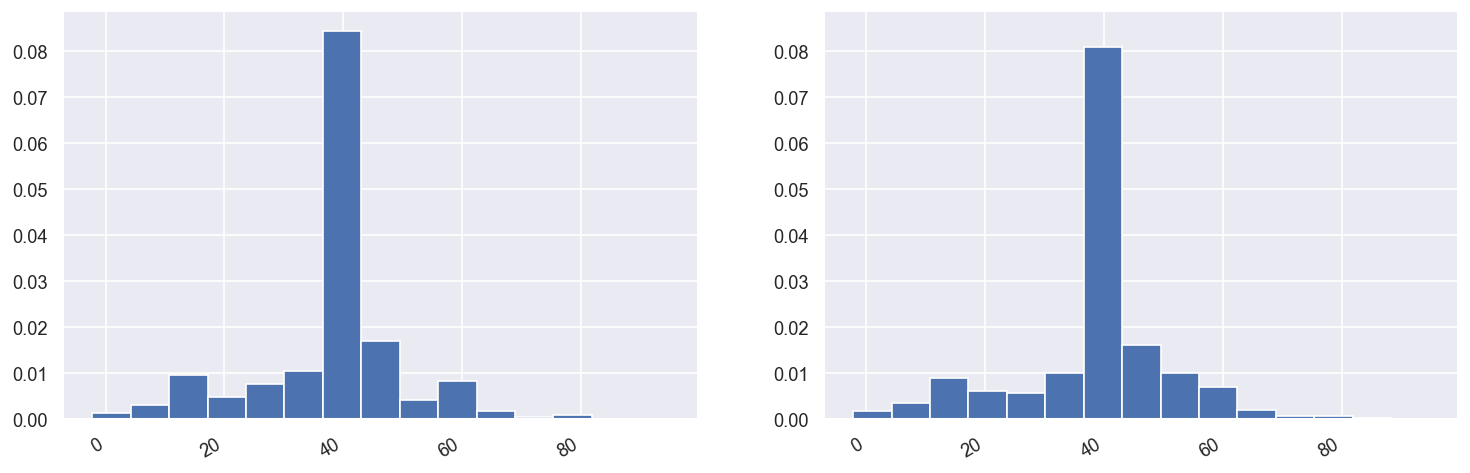

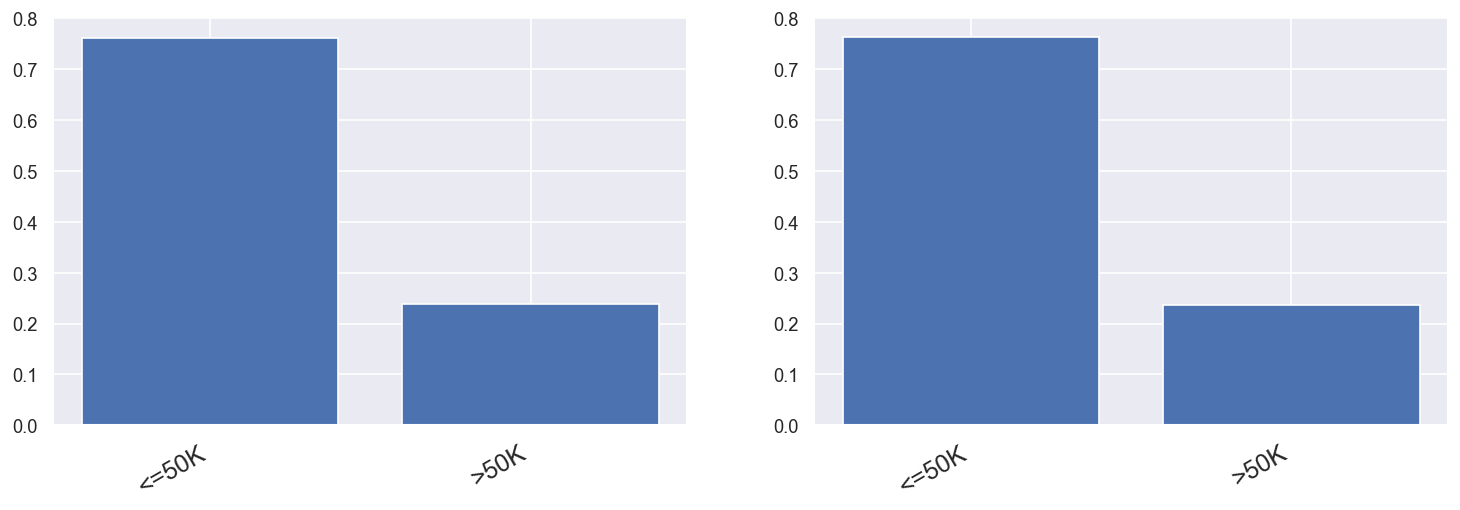

In [10]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

#### 5.3 compare pairwise mutual information

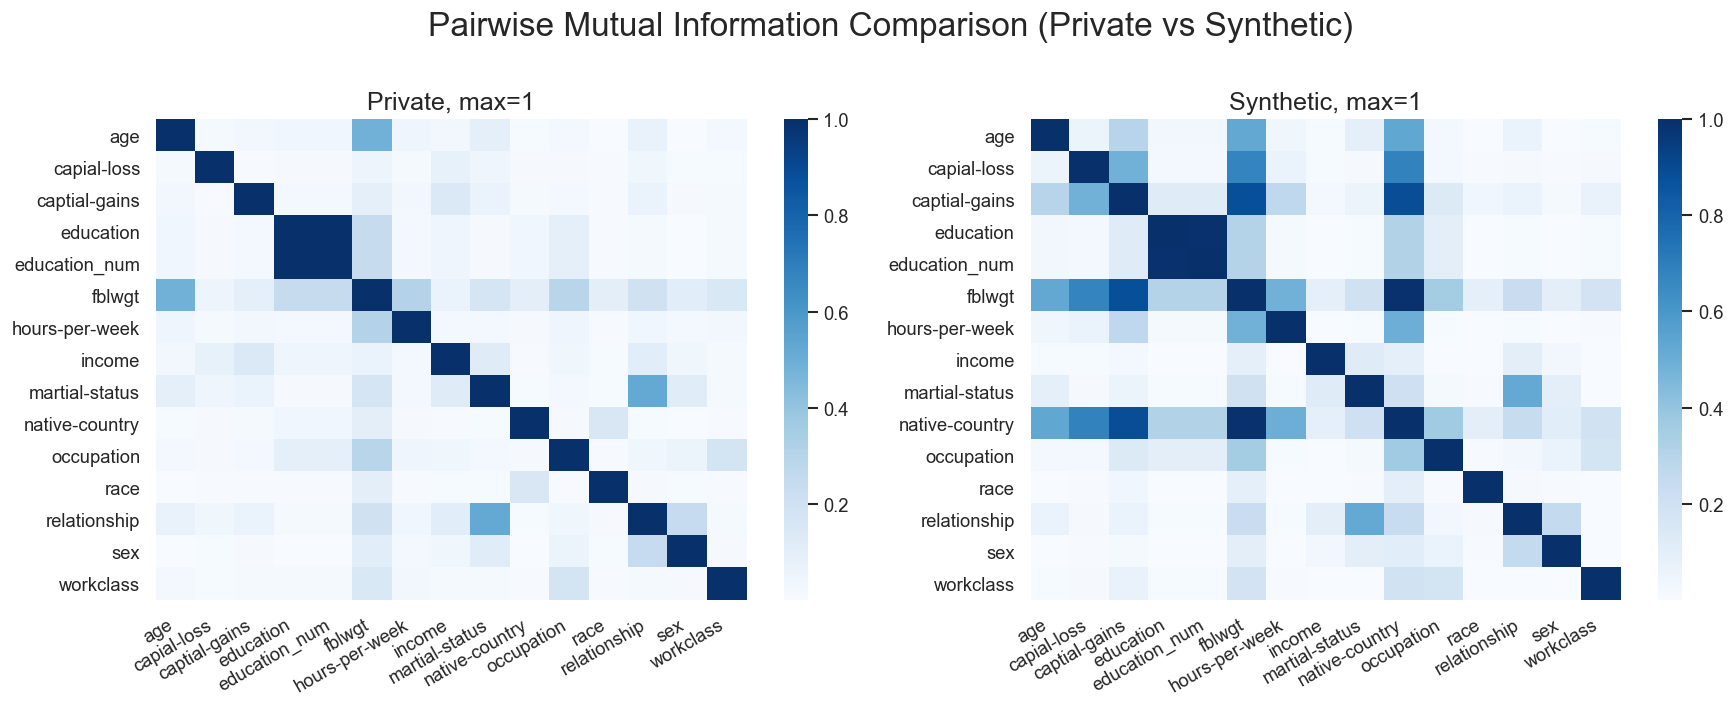

In [11]:
inspector.mutual_information_heatmap()